In [1155]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import optimize
import os
import pandas_datareader as pdr
import datetime
from scipy.stats import norm
# tqdm package shows a progress bar
from tqdm.notebook import trange, tqdm
# Disable the chain assignment warning
pd.options.mode.chained_assignment = None

PART 0: Data Preparation

0.1 FUNDA File

In [1164]:
# Import FUNDA file
s = os.path.sep

funda = pd.read_csv("C:" + s + "_Ga Tech" + s + "MS QCF" + s + "2021 Fall" + s + "MGT6090" + s + "Assignment 10" + s + "funda.csv", 
                    skipinitialspace = True, low_memory=False)

In [77]:
# Apply fileters to funda dataset
funda_filters = (funda.indfmt=='INDL')&(funda.datafmt=='STD')&(funda.popsrc=='D')&(funda.fic=='USA')&(funda.consol=='C')\
                 &(funda.datadate>=19690101)&(funda.datadate<=20201231)
funda_columns = ['cusip', 'datadate', 'dlc', 'dltt']

funda_reduced = funda[funda_filters].loc[:, funda_columns]

In [80]:
# Mutate funda_reduced
funda_reduced['cusip'] = funda_reduced['cusip'].str[0:6]
funda_reduced['year'] = pd.DatetimeIndex(pd.to_datetime(funda_reduced['datadate'].astype(str), format='%Y%m%d')).year
funda_reduced['f'] = funda_reduced['dlc'] + funda_reduced['dltt'] * 0.5
funda_reduced['f'] = funda_reduced.groupby(by=['cusip'])['f'].shift()
funda_reduced['f'] = funda_reduced['f'] * 1000000

In [83]:
# Drop rows with f==0, which will be invalid in later calculations
funda_reduced = funda_reduced[(funda_reduced['year']>=1970) & (funda_reduced['f']>0)][['cusip','year','f']].dropna()


In [1165]:
# funda file no longer needed, delete to release memory
del funda

0.2 DSF File

In [1167]:
# Import DSF file
 dsf = pd.read_csv("C:" + s + "_Ga Tech" + s + "MS QCF" + s + "2021 Fall" + s + "MGT6090" + s + "Assignment 10" + s + "dsf_new.csv", 
                      skipinitialspace = True, usecols = ['DATE', 'CUSIP', 'PRC', 'RET', 'SHROUT'], low_memory=False)


In [88]:
# Apply filters to DSF dataset
dsf_filters = (dsf.DATE>=19690101)&(dsf.DATE <= 20201231)
dsf_reduced = dsf[dsf_filters]
dsf_reduced.columns = dsf_reduced.columns.str.lower()

In [1161]:
# dsf file no longer needed, delete to release memory
del dsf

In [1168]:
# Mutate dsf_reduced

dsf_reduced['cusip'] = dsf_reduced['cusip'].str[0:6]
dsf_reduced['year'] = pd.DatetimeIndex(pd.to_datetime(dsf_reduced['date'].astype(str), format='%Y%m%d')).year
dsf_reduced['daily_e'] = abs(dsf_reduced['prc']) * dsf_reduced['shrout'] * 1000
dsf_reduced['ret'] = pd.to_numeric(dsf_reduced['ret'], errors='coerce')



In [ ]:
# force 'ret' column to float
dsf_reduced.loc[:,'ret'] = pd.to_numeric(dsf_reduced.loc[:,'ret'], errors='coerce')

In [93]:
dsf_reduced = dsf_reduced[['cusip','year','ret','daily_e']].dropna()

In [216]:
# Yearly return
annret = dsf_reduced.groupby(by = ['cusip', 'year']).apply(lambda x: np.sum(np.log(1+x['ret'])))

In [217]:
annret = pd.DataFrame(annret)

In [218]:
annret = annret.reset_index()

In [219]:
annret.rename(columns={0:'r'}, inplace=True)

In [220]:
# Lag return 
annret['r'] = annret.groupby(by=['cusip'])['r'].shift()

In [136]:
# Yearly standard deviation
sigmae = dsf_reduced.groupby(by = ['cusip', 'year'])['ret'].std()*np.sqrt(250)

In [137]:
sigmae = pd.DataFrame(sigmae)

In [139]:
sigmae = sigmae.reset_index()

In [140]:
sigmae.rename(columns={'ret':'r_sd'}, inplace=True)

In [142]:
# Lag standard deviation
sigmae['r_sd'] = sigmae.groupby(by=['cusip'])['r_sd'].shift()

In [146]:
# Yearly equity value
e = dsf_reduced.groupby(by = ['cusip', 'year'])['daily_e'].first()

In [149]:
e = pd.DataFrame(e.reset_index())

In [151]:
e.rename(columns={'daily_e':'equity'}, inplace=True)

In [226]:
# Combine data from funda and dsf 
combined = annret.merge(sigmae, on=['cusip','year']).merge(e, on=['cusip','year'])

In [227]:
combined = funda_reduced.merge(combined, on=['cusip','year']).dropna()

In [193]:
# Get risk-free rate from FRED
start = datetime.datetime (1970, 1, 1)
end = datetime.datetime (2020, 12, 31)
dailyfed = pdr.DataReader('DTB3', 'fred', start, end)

In [196]:
dailyfed = dailyfed.dropna()

In [1169]:
dailyfed['rf'] = np.log(1+dailyfed['DTB3']/100)

In [203]:
dailyfed = dailyfed.reset_index()

In [212]:
dailyfed['year'] = dailyfed['DATE'].dt.year

In [214]:
dailyfed = dailyfed.groupby(by=['year'])['rf'].first()

In [231]:
dailyfed = dailyfed.reset_index()

In [234]:
# Combine risk-free rate data with other data
combined = combined.merge(dailyfed, how='left', on='year')

PART 1: Method 1 (Naive Computation)

In [245]:
# Create a random sample set for this part

method_1_data = combined.groupby(by=['year']).apply(lambda x: x.sample(n=1000, random_state=1) if x.shape[0]>=1000 else x).reset_index(drop=True)

In [249]:
# Calculate total asset
method_1_data.loc[:,'v'] = method_1_data.loc[:,'f'] + method_1_data.loc[:,'equity']

In [251]:
# Calculate standard deviation of debt
method_1_data.loc[:,'sd_d_1'] = 0.05 + 0.25 * method_1_data.loc[:,'r_sd']
method_1_data.loc[:,'sd_d_2'] = 0.05 + 0.5 * method_1_data.loc[:,'r_sd']
method_1_data.loc[:,'sd_d_3'] = 0.25 * method_1_data.loc[:,'r_sd']

In [253]:
# Calculate standard deviation of total asset
method_1_data.loc[:,'sd_v_1'] = method_1_data.loc[:,'r_sd']*method_1_data.loc[:,'equity'] / method_1_data.loc[:,'v'] + \
                                method_1_data.loc[:,'sd_d_1']*method_1_data.loc[:,'f'] / method_1_data.loc[:,'v']
method_1_data.loc[:,'sd_v_2'] = method_1_data.loc[:,'r_sd']*method_1_data.loc[:,'equity'] / method_1_data.loc[:,'v'] + \
                                method_1_data.loc[:,'sd_d_2']*method_1_data.loc[:,'f'] / method_1_data.loc[:,'v']
method_1_data.loc[:,'sd_v_3'] = method_1_data.loc[:,'r_sd']*method_1_data.loc[:,'equity'] / method_1_data.loc[:,'v'] + \
                                method_1_data.loc[:,'sd_d_3']*method_1_data.loc[:,'f'] / method_1_data.loc[:,'v']

In [255]:
# Calculate Distance to Default
method_1_data.loc[:,'dd_1'] = (np.log(method_1_data.loc[:,'v']/method_1_data.loc[:,'f'])+ \
                               (method_1_data.loc[:,'r']-method_1_data.loc[:,'sd_v_1']**2 / 2))/method_1_data.loc[:,'sd_v_1']
method_1_data.loc[:,'dd_2'] = (np.log(method_1_data.loc[:,'v']/method_1_data.loc[:,'f'])+ \
                               (method_1_data.loc[:,'r']-method_1_data.loc[:,'sd_v_2']**2 / 2))/method_1_data.loc[:,'sd_v_2']
method_1_data.loc[:,'dd_3'] = (np.log(method_1_data.loc[:,'v']/method_1_data.loc[:,'f'])+ \
                               (method_1_data.loc[:,'r']-method_1_data.loc[:,'sd_v_3']**2 / 2))/method_1_data.loc[:,'sd_v_3']

In [260]:
# Calculate Possibility of Default
method_1_data.loc[:,'pd_1'] = norm.cdf(-method_1_data.loc[:,'dd_1'])
method_1_data.loc[:,'pd_2'] = norm.cdf(-method_1_data.loc[:,'dd_2'])
method_1_data.loc[:,'pd_3'] = norm.cdf(-method_1_data.loc[:,'dd_3'])

In [264]:
# Create a dataframe to store Mothod 1 results
md_1_result = method_1_data[['cusip', 'year', 'dd_1','dd_2','dd_3','pd_1','pd_2','pd_3']]

In [726]:
md_1_result.replace([np.inf, -np.inf], np.nan, inplace=True)

In [759]:
# Save the results as a csv file
md_1_result.to_csv('md_1_result.csv')

PART 2: Method 2 (Directly Solving Two Unknowns)

In [320]:
# Use the same stock selection with Method 1
md_2_data = method_1_data[['cusip','year','f','equity','rf','r','r_sd']]

In [322]:
# Create a function to solve v and sigma    
def solve_v_sigma(row):
    
    def eqs(result):
        (v,sig) = result
        first_eq = v*norm.cdf((np.log(v/row['f'])+(row['rf']+sig**2/2))/sig) - \
               np.exp(-row['rf'])*row['f']*norm.cdf((np.log(v/row['f'])+(row['rf']+sig**2/2))/sig - sig)-row['equity']
        second_eq = v*norm.cdf((np.log(v/row['f'])+(row['rf']+sig**2/2))/sig)*sig/row['equity'] - row['r_sd']
        return [first_eq, second_eq]
    
    return optimize.root(eqs, [row['equity']+row['f'],0.25])
    
    

In [1170]:
# Solve v and sigma
md_2_data.loc[:,'root'] = md_2_data.apply(solve_v_sigma, axis=1)

In [325]:
# Extract v and sigma from OptimizeResult object
md_2_data.loc[:,'v'] = md_2_data.apply(lambda x: x['root'].x[0], axis=1)
md_2_data.loc[:,'sd_v'] = md_2_data.apply(lambda x: x['root'].x[1], axis=1)

In [1171]:
# Calculate DD 
md_2_data.loc[:,'dd'] = (np.log(md_2_data.loc[:,'v']/md_2_data.loc[:,'f'])+ \
                               (md_2_data.loc[:,'r']-md_2_data.loc[:,'sd_v']**2 / 2))/md_2_data.loc[:,'sd_v']

In [1172]:
# Calculate PD
md_2_data.loc[:,'pd'] = norm.cdf(-md_2_data.loc[:,'dd'])

In [332]:
# Create a dataframe to store the result for Method 2
md_2_result = md_2_data[['cusip','year','dd','pd']]

In [764]:
md_2_result.replace([np.inf, -np.inf], np.nan, inplace=True)

In [765]:
# Save the dataframe as csv
md_2_result.to_csv('md_2_result.csv')

PART 3: METHOD 3 (Solve two Unknowns Iteratively)

In [339]:
# Randomly select 250 firms for each year
list_250 = combined.groupby(by=['year']).apply(lambda x: x.sample(n=250, random_state=1)).reset_index(drop=True)[['cusip','year']]

In [350]:
list_250.loc[:,'label'] = 1

In [354]:
# Extract data for each firm on the list from DSF
md_3_data = dsf_reduced.merge(list_250, how = 'left',on=['cusip','year'])

In [367]:
md_3_data = md_3_data.loc[md_3_data.label == 1][['cusip','year','daily_e']]

In [369]:
md_3_data = md_3_data.merge(combined[['cusip','year','f','rf','r']], how='left', on=['cusip','year'])

In [470]:
# Write a function to iteratatively calculate v and sd_v
def iter_v_sigma(df):
    n = df.shape[0]
    tol = 0.0001
    sig_old = 0
    sig_new = 0.25
    v_list = []
    
    # Create limit for iteration. 
    iteration_limit = 100
    counter = 0
    
    def solve_v(row,sig):
    
        def eq(v):
            equation = v*norm.cdf((np.log(v/row['f'])+(row['rf']+sig**2/2))/sig) - \
                   np.exp(-row['rf'])*row['f']*norm.cdf((np.log(v/row['f'])+(row['rf']+sig**2/2))/sig - sig)-row['daily_e']
            return equation
        
        return optimize.root(eq, [row['daily_e']+row['f']]).x[0]
    
    while((abs(sig_new - sig_old) > tol) & (counter <= iteration_limit)):
        for i in range(n):
            v_list.append(solve_v(df.iloc[i,:], sig_new))
            
        v_sigma = np.std(v_list) / np.mean(v_list)
        
        sig_old = sig_new
        sig_new = v_sigma
        counter = counter + 1
    
    # Check if counter over the limit. If so, let the user know.
    if counter > iteration_limit:
        print('Max iteration limit exceeded, most recent iteration is used as result.')
        print('Iteration error is:')
        print(abs(sig_new - sig_old))

    return [sig_new, np.mean(v_list)]
        

In [1173]:
# Calculate v and sigma of v iteratively
iter_result = md_3_data.groupby(by=['year','cusip']).progress_apply(iter_v_sigma)

In [474]:
iter_result = iter_result.reset_index()

In [475]:
iter_result.rename(columns={0:'result'}, inplace=True)

In [476]:
iter_result.loc[:,'it_sd_v'] = iter_result.apply(lambda x: x.result[0], axis=1)

In [477]:
iter_result.loc[:,'it_v'] = iter_result.apply(lambda x: x.result[1], axis=1)

In [481]:
# Save the result to a csv file
iter_result.to_csv('md_3_iter_result.csv')

In [523]:
# Gather data for DD and PD calculation
md_3_final_data = iter_result.loc[:,['year','cusip','it_sd_v','it_v']].merge(funda_reduced, how='left', on=['year','cusip'])

In [528]:
md_3_final_data = md_3_final_data.drop_duplicates()

In [530]:
md_3_final_data = md_3_final_data.merge(annret, how='left', on=['year','cusip'])

In [532]:
# Calculate DD
md_3_final_data.loc[:,'dd'] = (np.log(md_3_final_data.loc[:,'it_v']/md_3_final_data.loc[:,'f'])+ \
                               (md_3_final_data.loc[:,'r']-md_3_final_data.loc[:,'it_sd_v']**2 / 2))/md_3_final_data.loc[:,'it_sd_v']


In [533]:
# Calculate PD
md_3_final_data.loc[:,'pd'] = norm.cdf(-md_3_final_data.loc[:,'dd'])

In [534]:
# Create a dataframe to store the result for Method 3
md_3_result = md_3_final_data[['cusip','year','dd','pd']]

In [774]:
md_3_result.replace([np.inf, -np.inf], np.nan, inplace=True)

In [775]:
# Save the dataframe as csv
md_3_result.to_csv('md_3_result.csv')

PART 4: Data Analysis

4.0 Get Macro Economic Data

In [545]:
# Set start and end date
start = datetime.datetime (1970, 1, 1)
end = datetime.datetime (2020, 12, 31)


In [562]:
# Get NBER recession data
nber = pdr.DataReader('USREC', 'fred', start, end)

In [563]:
nber = nber.reset_index()

In [566]:
# Reduce NBER from monthly to yearly in order to match the data frequency with our DD and PD
# For simplicity, as long as there is at least one month considered as recession, that whole year would be recession
nber_reduced = nber.copy()

In [568]:
# Add 'YEAR' column in order to reduce NBER to yearly
nber_reduced.loc[:,'YEAR'] = nber_reduced.apply(lambda x: x.DATE.year, axis=1)

In [574]:
# The trick is to group by YEAR and take sum.
# If there is at least one month recession in that year, that year will be marked as recession.
nber_reduced = nber_reduced.loc[:,['YEAR','USREC']].groupby(by=['YEAR']).sum().reset_index()

In [579]:
nber_reduced.loc[:,'USREC'][nber_reduced['USREC']>0] = 1

In [582]:
# Get Moody's BAA-Fed Fund Spread
baa = pdr.DataReader('BAAFFM', 'fred', start, end)

In [584]:
baa = baa.reset_index()

In [591]:
# Cleveland Financial Stress Index has been discontinued. Use KCFSI instead.
# Get Kansas City Financial Stress Index
kcfsi = pdr.DataReader('KCFSI', 'fred', start, end)

In [592]:
kcfsi = kcfsi.reset_index()

In [596]:
# Convert their column names to lower case
nber.columns = nber.columns.str.lower()
nber_reduced.columns = nber_reduced.columns.str.lower()
baa.columns = baa.columns.str.lower()
kcfsi.columns = kcfsi.columns.str.lower()

4.1 Tabulate DD and PD for METHOD 1, 2, 3

In [727]:
# Merge NBER yearly data with the results of Method 1, 2, 3
md_1_result_nber = md_1_result.merge(nber_reduced, how='left', on=['year'])

In [768]:
md_2_result_nber = md_2_result.merge(nber_reduced, how='left', on=['year'])

In [776]:
md_3_result_nber = md_3_result.merge(nber_reduced, how='left', on=['year'])

In [823]:
# Make table for DD from Method 1.1
dd_1_1 = md_1_result_nber.groupby('year')['dd_1'].describe().reset_index()

In [824]:
dd_1_1.style.set_caption("DD using Method 1_1")

,year,count,mean,std,min,25%,50%,75%,max
0,1970,599.000000,5.997667,5.730149,-4.933843,2.064806,4.753318,8.421126,41.820725
1,1971,646.000000,5.040213,4.405269,-3.277973,1.955153,4.250258,7.256422,24.386927
2,1972,680.000000,6.999921,5.421328,-1.077027,3.378891,5.633704,9.154388,36.331652
3,1973,1000.000000,10.254145,23.346186,-2.201573,3.670741,6.621237,11.008209,536.185498
4,1974,1000.000000,3.653515,25.028316,-7.365506,0.187483,2.174269,4.648621,782.608241
5,1975,1000.000000,2.021799,4.477619,-9.105269,-0.404991,1.359732,3.683588,64.608055
6,1976,1000.000000,5.006356,4.132196,-4.732966,2.441993,4.181522,6.804174,39.153772
7,1977,1000.000000,6.367562,4.931531,-2.623426,2.958063,5.622677,8.634888,41.105885
8,1978,1000.000000,7.359033,24.528814,-3.106522,3.063171,5.572135,8.329747,752.320425
9,1979,1000.000000,5.385362,6.312164,-3.591232,2.412380,4.314729,6.741772,110.628693


In [825]:
# Make table for PD from Method 1.1
pd_1_1 = md_1_result_nber.groupby('year')['pd_1'].describe().reset_index()

In [826]:
pd_1_1.style.set_caption("PD using Method 1_1")

,year,count,mean,std,min,25%,50%,75%,max
0,1970,599.000000,0.086019,0.218670,0.000000,0.000000,0.000001,0.019479,1.000000
1,1971,646.000000,0.089912,0.211595,0.000000,0.000000,0.000011,0.025286,0.999477
2,1972,680.000000,0.021590,0.085521,0.000000,0.000000,0.000000,0.000364,0.859266
3,1973,1000.000000,0.026493,0.105846,0.000000,0.000000,0.000000,0.000121,0.986152
4,1974,1000.000000,0.239779,0.352967,0.000000,0.000002,0.014844,0.425643,1.000000
5,1975,1000.000000,0.313288,0.374857,0.000000,0.000115,0.086957,0.657257,1.000000
6,1976,1000.000000,0.051868,0.154741,0.000000,0.000000,0.000014,0.007304,0.999999
7,1977,1000.000000,0.043140,0.142592,0.000000,0.000000,0.000000,0.001548,0.995647
8,1978,1000.000000,0.050729,0.164746,0.000000,0.000000,0.000000,0.001095,0.999053
9,1979,1000.000000,0.058367,0.172621,0.000000,0.000000,0.000008,0.007925,0.999835


In [827]:
# Make table for DD from Method 1.2
dd_1_2 = md_1_result_nber.groupby('year')['dd_2'].describe().reset_index()

In [828]:
dd_1_2.style.set_caption("DD using Method 1_2")

,year,count,mean,std,min,25%,50%,75%,max
0,1970,599.000000,5.799441,5.715365,-3.672466,1.882346,4.431031,8.155178,41.812788
1,1971,646.000000,4.796147,4.381619,-2.503303,1.726704,3.896360,6.835860,24.382758
2,1972,680.000000,6.672266,5.478906,-0.966782,2.954987,5.175598,8.791469,36.295548
3,1973,1000.000000,9.911233,23.365863,-1.806433,3.290328,6.209131,10.663891,536.185498
4,1974,1000.000000,3.559243,24.956222,-4.407002,0.088421,1.965938,4.312452,781.009084
5,1975,1000.000000,1.970913,4.283525,-5.565934,-0.398376,1.121602,3.346357,64.388584
6,1976,1000.000000,4.599330,4.151796,-2.909711,1.955072,3.647623,6.308075,39.060367
7,1977,1000.000000,5.953174,4.949757,-2.008459,2.459101,5.208899,8.047652,41.105110
8,1978,1000.000000,6.955722,24.543666,-2.231661,2.607834,5.114410,7.676431,752.320425
9,1979,1000.000000,5.033039,6.321951,-2.606560,1.980848,3.852173,6.373582,110.628693


In [829]:
# Make table for PD from Method 1.2
pd_1_2 = md_1_result_nber.groupby('year')['pd_2'].describe().reset_index()

In [830]:
pd_1_2.style.set_caption("PD using Method 1_2")

,year,count,mean,std,min,25%,50%,75%,max
0,1970,599.000000,0.090696,0.216717,0.000000,0.000000,0.000005,0.029897,0.999880
1,1971,646.000000,0.097388,0.212972,0.000000,0.000000,0.000049,0.042110,0.993848
2,1972,680.000000,0.027807,0.095330,0.000000,0.000000,0.000000,0.001563,0.833173
3,1973,1000.000000,0.032021,0.112109,0.000000,0.000000,0.000000,0.000501,0.964575
4,1974,1000.000000,0.244974,0.344952,0.000000,0.000008,0.024654,0.464771,0.999995
5,1975,1000.000000,0.321474,0.362702,0.000000,0.000409,0.131021,0.654822,1.000000
6,1976,1000.000000,0.066683,0.165073,0.000000,0.000000,0.000132,0.025288,0.998191
7,1977,1000.000000,0.053935,0.149973,0.000000,0.000000,0.000000,0.006971,0.977703
8,1978,1000.000000,0.058787,0.167115,0.000000,0.000000,0.000000,0.004557,0.987181
9,1979,1000.000000,0.068885,0.175276,0.000000,0.000000,0.000059,0.023804,0.995427


In [831]:
# Make table for DD from Method 1.3
dd_1_3 = md_1_result_nber.groupby('year')['dd_3'].describe().reset_index()

In [832]:
dd_1_3.style.set_caption("DD using Method 1_3")

,year,count,mean,std,min,25%,50%,75%,max
0,1970,599.000000,6.180311,5.765047,-6.475199,2.176607,5.086983,8.656815,41.829876
1,1971,646.000000,5.227148,4.456279,-3.601359,2.037270,4.501850,7.712958,24.389727
2,1972,680.000000,7.288270,5.413664,-1.128149,3.604430,6.073793,9.606017,36.377094
3,1973,993.000000,9.538913,10.408367,-2.325082,3.964460,7.192805,11.654557,186.200584
4,1974,1000.000000,3.822604,26.957220,-9.039322,0.224160,2.337342,5.044608,843.751695
5,1975,1000.000000,2.077488,4.662038,-12.429381,-0.398674,1.493163,3.935493,65.265146
6,1976,999.000000,5.308988,4.202652,-5.562444,2.666513,4.531082,7.167270,39.308549
7,1977,999.000000,6.797667,5.069873,-3.241740,3.209284,6.025333,9.311716,41.106546
8,1978,996.000000,6.979130,6.016203,-4.295791,3.492074,6.104260,9.236973,92.217427
9,1979,998.000000,8.582266,94.413047,-4.649880,2.681870,4.685347,7.470151,2984.714621


In [833]:
# Make table for PD from Method 1.3
pd_1_3 = md_1_result_nber.groupby('year')['pd_3'].describe().reset_index()

In [834]:
pd_1_3.style.set_caption("PD using Method 1_3")

,year,count,mean,std,min,25%,50%,75%,max
0,1970,599.000000,0.083910,0.220339,0.000000,0.000000,0.000000,0.014756,1.000000
1,1971,646.000000,0.087235,0.211769,0.000000,0.000000,0.000003,0.020812,0.999842
2,1972,680.000000,0.019367,0.082122,0.000000,0.000000,0.000000,0.000157,0.870371
3,1973,1000.000000,0.024361,0.104171,0.000000,0.000000,0.000000,0.000036,0.989966
4,1974,1000.000000,0.236890,0.357250,0.000000,0.000000,0.009713,0.411318,1.000000
5,1975,1000.000000,0.310423,0.381305,0.000000,0.000042,0.067698,0.654933,1.000000
6,1976,1000.000000,0.048013,0.153036,0.000000,0.000000,0.000003,0.003830,1.000000
7,1977,1000.000000,0.039677,0.141415,0.000000,0.000000,0.000000,0.000658,0.999406
8,1978,1000.000000,0.047982,0.165808,0.000000,0.000000,0.000000,0.000238,0.999991
9,1979,1000.000000,0.054563,0.173669,0.000000,0.000000,0.000001,0.003640,0.999998


In [835]:
# Make table for DD from Method 2
dd_2 = md_2_result_nber.groupby('year')['dd'].describe().reset_index()

In [836]:
dd_2.style.set_caption("DD using Method 2")

,year,count,mean,std,min,25%,50%,75%,max
0,1970,599.000000,6.251881,5.927259,-12.509070,2.340326,5.296628,8.870177,41.835169
1,1971,646.000000,5.442305,4.582631,-10.224746,2.324775,4.857583,8.016999,24.393015
2,1972,680.000000,7.695881,5.347833,-1.393886,4.051715,6.583533,10.130225,36.407325
3,1973,1000.000000,55177160916321880.000000,1707493539892075264.000000,-3.259560,4.295703,7.706321,12.282808,53983690140433989632.000000
4,1974,1000.000000,3.482812,27.310762,-74.278156,0.144506,2.514434,5.239059,844.976251
5,1975,1000.000000,1.314467,6.889155,-60.774957,-0.701585,1.704971,4.208654,65.419718
6,1976,1000.000000,6.108854,8.234416,-49.067199,3.183699,5.315452,7.962892,207.940633
7,1977,1000.000000,7.640332,7.540703,-32.230026,3.935407,6.657160,10.139864,165.265070
8,1978,1000.000000,27917256848.670918,736553167585.604004,-67.221756,4.080552,6.818840,10.033122,22990188292504.875000
9,1979,1000.000000,66267.442892,2094934.448190,-16.021628,3.035152,5.122586,8.197345,66247662.972451


In [837]:
# Make table for PD from Method 2
pd_2 = md_2_result_nber.groupby('year')['pd'].describe().reset_index()

In [838]:
pd_2.style.set_caption("PD using Method 2")

,year,count,mean,std,min,25%,50%,75%,max
0,1970,599.000000,0.085899,0.230456,0.000000,0.000000,0.000000,0.009634,1.000000
1,1971,646.000000,0.085297,0.218736,0.000000,0.000000,0.000001,0.010045,1.000000
2,1972,680.000000,0.016132,0.079477,0.000000,0.000000,0.000000,0.000025,0.918324
3,1973,1000.000000,0.022848,0.110746,0.000000,0.000000,0.000000,0.000009,0.999442
4,1974,1000.000000,0.246790,0.373533,0.000000,0.000000,0.005961,0.442551,1.000000
5,1975,1000.000000,0.322579,0.404415,0.000000,0.000013,0.044100,0.758508,1.000000
6,1976,1000.000000,0.042474,0.158328,0.000000,0.000000,0.000000,0.000727,1.000000
7,1977,1000.000000,0.035125,0.147453,0.000000,0.000000,0.000000,0.000042,1.000000
8,1978,1000.000000,0.048501,0.181567,0.000000,0.000000,0.000000,0.000022,1.000000
9,1979,1000.000000,0.057872,0.196075,0.000000,0.000000,0.000000,0.001202,1.000000


In [839]:
# Make table for DD from Method 3
dd_3 = md_3_result_nber.groupby('year')['dd'].describe().reset_index()

In [840]:
dd_3.style.set_caption("DD using Method 3")

,year,count,mean,std,min,25%,50%,75%,max
0,1970,251.000000,13.361771,13.900473,-28.265382,3.688375,10.963992,19.815440,64.669117
1,1971,251.000000,22.411729,18.043921,-22.313518,10.083416,21.025836,31.332214,104.163799
2,1972,251.000000,25.496092,17.334851,-0.969072,13.493964,21.450904,32.140799,131.860219
3,1973,250.000000,17.013532,16.375342,-17.078555,7.821747,13.689475,20.342937,150.483823
4,1974,250.000000,5.902606,13.925187,-92.431210,0.440818,5.539538,12.404140,61.604220
5,1975,250.000000,9.622538,31.870626,-93.774402,-0.439940,7.879404,17.394653,339.957018
6,1976,250.000000,26.168447,18.344334,-31.461055,15.037947,22.237344,34.595076,119.508885
7,1977,251.000000,27.717353,22.670830,-14.206015,13.293860,22.899487,37.704902,190.705462
8,1978,251.000000,20.793335,30.906892,-57.095750,9.728344,15.409947,26.252317,424.604350
9,1979,252.000000,23.830605,32.542626,-15.188831,10.382643,18.238108,30.132715,378.900282


In [841]:
# Make table for PD from Method 3
pd_3 = md_3_result_nber.groupby('year')['pd'].describe().reset_index()

In [842]:
pd_3.style.set_caption("PD using Method 3")

,year,count,mean,std,min,25%,50%,75%,max
0,1970,251.000000,0.113304,0.287650,0.000000,0.000000,0.000000,0.000128,1.000000
1,1971,251.000000,0.055995,0.218669,0.000000,0.000000,0.000000,0.000000,1.000000
2,1972,251.000000,0.006166,0.065886,0.000000,0.000000,0.000000,0.000000,0.833745
3,1973,250.000000,0.019688,0.123177,0.000000,0.000000,0.000000,0.000000,1.000000
4,1974,250.000000,0.235355,0.402498,0.000000,0.000000,0.000000,0.329691,1.000000
5,1975,250.000000,0.264550,0.424313,0.000000,0.000000,0.000000,0.669424,1.000000
6,1976,250.000000,0.028247,0.155637,0.000000,0.000000,0.000000,0.000000,1.000000
7,1977,251.000000,0.024070,0.146372,0.000000,0.000000,0.000000,0.000000,1.000000
8,1978,251.000000,0.031305,0.164879,0.000000,0.000000,0.000000,0.000000,1.000000
9,1979,252.000000,0.028374,0.155323,0.000000,0.000000,0.000000,0.000000,1.000000


In [843]:
# Make table for DD from Method 1.1 based on NBER recession label
dd_1_1_nber = md_1_result_nber.groupby(by=['usrec'])['dd_1'].describe().reset_index()

In [844]:
dd_1_1_nber.style.set_caption("DD using Method 1_1 NBER")

,usrec,count,mean,std,min,25%,50%,75%,max
0,0,37326.000000,13.690688,1091.361403,-9.831939,2.475589,4.986195,8.184381,193881.294104
1,1,12599.000000,5.708059,74.201293,-10.847049,1.286330,3.820024,7.041952,8229.767688


In [845]:
# Make table for PD from Method 1.1 based on NBER recession label
pd_1_1_nber = md_1_result_nber.groupby(by=['usrec'])['pd_1'].describe().reset_index()

In [846]:
pd_1_1_nber.style.set_caption("PD using Method 1_1 NBER")

,usrec,count,mean,std,min,25%,50%,75%,max
0,0,37326.000000,0.074155,0.204140,0.000000,0.000000,0.000000,0.006651,1.000000
1,1,12599.000000,0.148546,0.293775,0.000000,0.000000,0.000067,0.099164,1.000000


In [847]:
# Make table for DD from Method 1.2 based on NBER recession label
dd_1_2_nber = md_1_result_nber.groupby(by=['usrec'])['dd_2'].describe().reset_index()

In [848]:
dd_1_2_nber.style.set_caption("DD using Method 1_2 NBER")

,usrec,count,mean,std,min,25%,50%,75%,max
0,0,37326.000000,13.436725,1091.363091,-9.133507,2.185857,4.657853,7.866709,193881.294104
1,1,12599.000000,5.518319,74.193920,-6.820886,1.091286,3.493414,6.737193,8229.767688


In [849]:
# Make table for PD from Method 1.2 based on NBER recession label
pd_1_2_nber = md_1_result_nber.groupby(by=['usrec'])['pd_2'].describe().reset_index()

In [850]:
pd_1_2_nber.style.set_caption("PD using Method 1_2 NBER")

,usrec,count,mean,std,min,25%,50%,75%,max
0,0,37326.000000,0.081289,0.206694,0.000000,0.000000,0.000002,0.014413,1.000000
1,1,12599.000000,0.155446,0.290784,0.000000,0.000000,0.000238,0.137573,1.000000


In [851]:
# Make table for DD from Method 1.3 based on NBER recession label
dd_1_3_nber = md_1_result_nber.groupby(by=['usrec'])['dd_3'].describe().reset_index()

In [852]:
dd_1_3_nber.style.set_caption("DD using Method 1_3 NBER")

,usrec,count,mean,std,min,25%,50%,75%,max
0,0,37305.000000,6.227339,16.404719,-11.213845,2.635768,5.269529,8.536080,2984.714621
1,1,12586.000000,5.116799,9.731928,-12.429381,1.395589,4.086191,7.379275,843.751695


In [853]:
# Make table for PD from Method 1.3 based on NBER recession label
pd_1_3_nber = md_1_result_nber.groupby(by=['usrec'])['pd_3'].describe().reset_index()

In [854]:
pd_1_3_nber.style.set_caption("PD using Method 1_3 NBER")

,usrec,count,mean,std,min,25%,50%,75%,max
0,0,37326.000000,0.072052,0.204354,0.000000,0.000000,0.000000,0.004180,1.000000
1,1,12599.000000,0.146070,0.295642,0.000000,0.000000,0.000021,0.080721,1.000000


In [855]:
# Make table for DD from Method 2 based on NBER recession label
dd_2_nber = md_2_result_nber.groupby(by=['usrec'])['dd'].describe().reset_index()

In [856]:
dd_2_nber.style.set_caption("DD using Method 2 NBER")

,usrec,count,mean,std,min,25%,50%,75%,max
0,0,37326.000000,1273526692.839243,157580531812.244446,-935.623692,3.223538,5.903805,9.213229,22990188292504.875000
1,1,12598.000000,4379834967165598.500000,481079789120606592.000000,-190.114812,1.741478,4.519852,7.917797,53983690140433989632.000000


In [857]:
# Make table for PD from Method 2 based on NBER recession label
pd_2_nber = md_2_result_nber.groupby(by=['usrec'])['pd'].describe().reset_index()

In [858]:
pd_2_nber.style.set_caption("PD using Method 2 NBER")

,usrec,count,mean,std,min,25%,50%,75%,max
0,0,37326.000000,0.063317,0.206153,0.000000,0.000000,0.000000,0.000633,1.000000
1,1,12599.000000,0.142340,0.306149,0.000000,0.000000,0.000003,0.040796,1.000000


In [859]:
# Make table for DD from Method 3 based on NBER recession label
dd_3_nber = md_3_result_nber.groupby(by=['usrec'])['dd'].describe().reset_index()

In [860]:
dd_3_nber.style.set_caption("DD using Method 3 NBER")

,usrec,count,mean,std,min,25%,50%,75%,max
0,0,9537.000000,632740002160.878052,61785164229211.046875,-317298211.905672,9.548723,18.242306,30.764393,6033788724312149.000000
1,1,3262.000000,12.945864,21.427098,-275.650509,4.281449,10.695816,19.485462,447.360255


In [861]:
# Make table for PD from Method 3 based on NBER recession label
pd_3_nber = md_3_result_nber.groupby(by=['usrec'])['pd'].describe().reset_index()

In [862]:
pd_3_nber.style.set_caption("PD using Method 3 NBER")

,usrec,count,mean,std,min,25%,50%,75%,max
0,0,9537.000000,0.048457,0.203032,0.000000,0.000000,0.000000,0.000000,1.000000
1,1,3263.000000,0.131369,0.321009,0.000000,0.000000,0.000000,0.000009,1.000000


4.2 Correlations of DD and PD among METHODS 1, 2

NOTE: Since Method 3 only samples 250 companies each year and has completely different samples, its DD and PD can not be compared with results from Method 1 and Method 2. Method 1 and Method 2 have the same samples and thus the correlation among them can be evaluated. 

In [797]:
# Prepare datasets for correlation calculation
dd_pd = md_1_result.merge(md_2_result, how='left', on=['cusip','year'])

In [804]:
dd_pd = dd_pd.rename(columns={'dd_1':'dd_method_1_1','dd_2':'dd_method_1_2','dd_3':'dd_method_1_3','dd':'dd_method_2',\
                     'pd_1':'pd_method_1_1','pd_2':'pd_method_1_2','pd_3':'pd_method_1_3','pd':'pd_method_2'})

In [815]:
# DD correlation
dd_corr = dd_pd.loc[:,['dd_method_1_1','dd_method_1_2','dd_method_1_3','dd_method_2']].corr()

<AxesSubplot:>

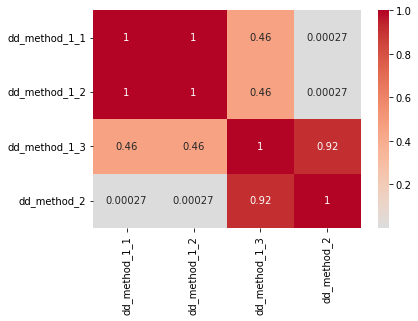

In [1158]:
# Visualize DD correlation
sns.heatmap(dd_corr, xticklabels=dd_corr.columns, yticklabels=dd_corr.columns, cmap='coolwarm', annot=True, center=0)

In [818]:
# PD correlation
pd_corr = dd_pd.loc[:,['pd_method_1_1','pd_method_1_2','pd_method_1_3','pd_method_2']].corr()

<AxesSubplot:>

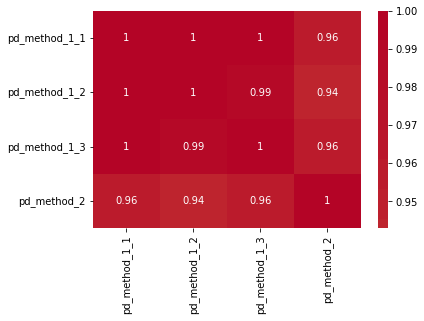

In [1159]:
# Visualize PD correlation
sns.heatmap(pd_corr, xticklabels=pd_corr.columns, yticklabels=pd_corr.columns, cmap='coolwarm', annot=True, center=0)

4.3 Plot DD and PD with NBER Recession Data

In [895]:
dd_1_1.loc[:,'year'] = pd.to_datetime(dd_1_1["year"], format='%Y')
dd_1_2.loc[:,'year'] = pd.to_datetime(dd_1_1["year"], format='%Y')
dd_1_3.loc[:,'year'] = pd.to_datetime(dd_1_1["year"], format='%Y')
dd_2.loc[:,'year'] = pd.to_datetime(dd_1_1["year"], format='%Y')
dd_3.loc[:,'year'] = pd.to_datetime(dd_1_1["year"], format='%Y')

pd_1_1.loc[:,'year'] = pd.to_datetime(dd_1_1["year"], format='%Y')
pd_1_2.loc[:,'year'] = pd.to_datetime(dd_1_1["year"], format='%Y')
pd_1_3.loc[:,'year'] = pd.to_datetime(dd_1_1["year"], format='%Y')
pd_2.loc[:,'year'] = pd.to_datetime(dd_1_1["year"], format='%Y')
pd_3.loc[:,'year'] = pd.to_datetime(dd_1_1["year"], format='%Y')

In [950]:
# Slightly modify nber dataset for the purpose of showing recession shade
nber.loc[:,'usrec'] = nber.loc[:,'usrec']*1000

Text(0, 0.5, 'Distance to Default')

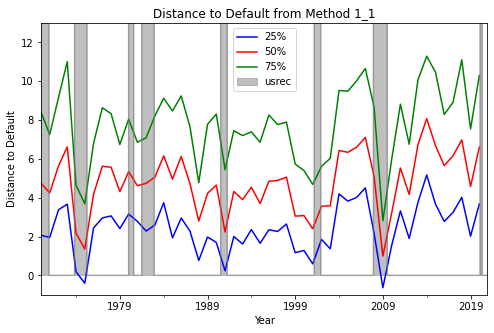

In [956]:
# DD of Method 1_1 with recession shade
fig, ax = plt.subplots()
dd_1_1[['year','25%','50%','75%']].plot.line(ax=ax, figsize=(8, 5), x='year', color=['blue','red','green'])
nber.plot.area(ax=ax, figsize=(8, 5), x='date', alpha=0.5, color="gray")
plt.ylim(-1, 13)
plt.title('Distance to Default from Method 1_1')
plt.xlabel('Year')
plt.ylabel('Distance to Default')

Text(0, 0.5, 'Distance to Default')

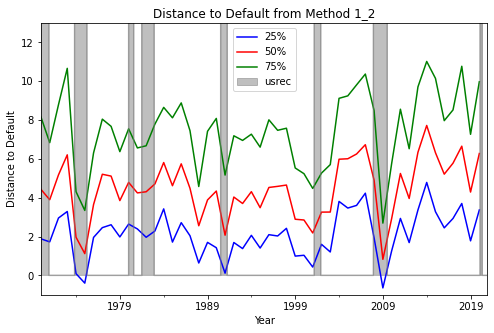

In [957]:
# DD of Method 1_2 with recession shade
fig, ax = plt.subplots()
dd_1_2[['year','25%','50%','75%']].plot.line(ax=ax, figsize=(8, 5), x='year', color=['blue','red','green'])
nber.plot.area(ax=ax, figsize=(8, 5), x='date', alpha=0.5, color="gray")
plt.ylim(-1, 13)
plt.title('Distance to Default from Method 1_2')
plt.xlabel('Year')
plt.ylabel('Distance to Default')

Text(0, 0.5, 'Distance to Default')

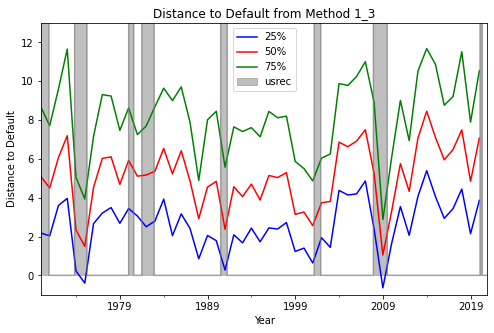

In [958]:
# DD of Method 1_3 with recession shade
fig, ax = plt.subplots()
dd_1_3[['year','25%','50%','75%']].plot.line(ax=ax, figsize=(8, 5), x='year', color=['blue','red','green'])
nber.plot.area(ax=ax, figsize=(8, 5), x='date', alpha=0.5, color="gray")
plt.ylim(-1, 13)
plt.title('Distance to Default from Method 1_3')
plt.xlabel('Year')
plt.ylabel('Distance to Default')

Text(0, 0.5, 'Distance to Default')

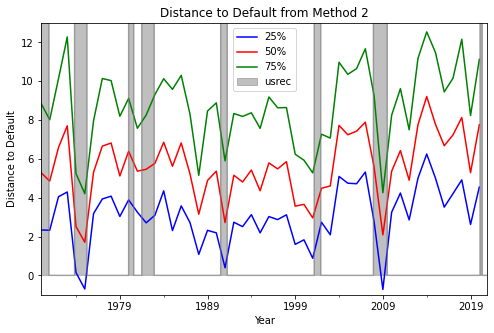

In [959]:
# DD of Method 2 with recession shade
fig, ax = plt.subplots()
dd_2[['year','25%','50%','75%']].plot.line(ax=ax, figsize=(8, 5), x='year', color=['blue','red','green'])
nber.plot.area(ax=ax, figsize=(8, 5), x='date', alpha=0.5, color="gray")
plt.ylim(-1, 13)
plt.title('Distance to Default from Method 2')
plt.xlabel('Year')
plt.ylabel('Distance to Default')

Text(0, 0.5, 'Distance to Default')

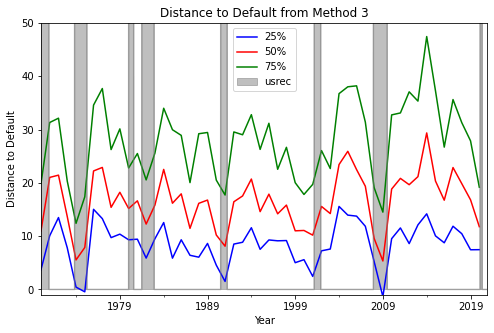

In [964]:
# DD of Method 3 with recession shade
fig, ax = plt.subplots()
dd_3[['year','25%','50%','75%']].plot.line(ax=ax, figsize=(8, 5), x='year', color=['blue','red','green'])
nber.plot.area(ax=ax, figsize=(8, 5), x='date', alpha=0.5, color="gray")
plt.ylim(-1, 50)
plt.title('Distance to Default from Method 3')
plt.xlabel('Year')
plt.ylabel('Distance to Default')

Text(0, 0.5, 'Probability of Default')

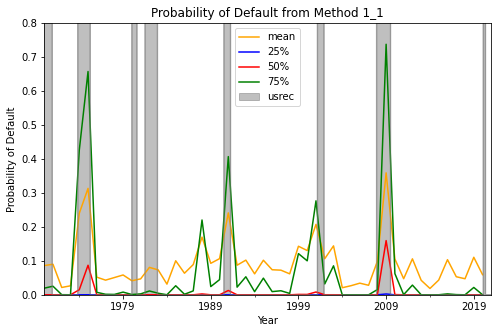

In [968]:
# PD of Method 1_1 with recession shade
fig, ax = plt.subplots()
pd_1_1[['year','mean','25%','50%','75%']].plot.line(ax=ax, figsize=(8, 5), x='year', color=['orange','blue','red','green'])
nber.plot.area(ax=ax, figsize=(8, 5), x='date', alpha=0.5, color="gray")
plt.ylim(0, 0.8)
plt.title('Probability of Default from Method 1_1')
plt.xlabel('Year')
plt.ylabel('Probability of Default')

Text(0, 0.5, 'Probability of Default')

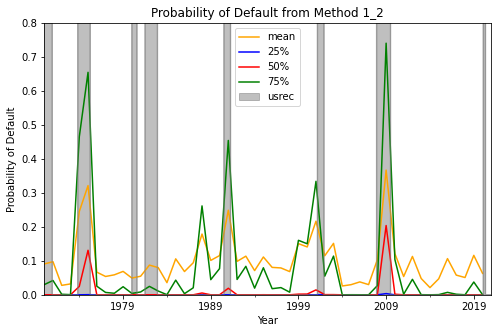

In [969]:
# PD of Method 1_2 with recession shade
fig, ax = plt.subplots()
pd_1_2[['year','mean','25%','50%','75%']].plot.line(ax=ax, figsize=(8, 5), x='year', color=['orange','blue','red','green'])
nber.plot.area(ax=ax, figsize=(8, 5), x='date', alpha=0.5, color="gray")
plt.ylim(0, 0.8)
plt.title('Probability of Default from Method 1_2')
plt.xlabel('Year')
plt.ylabel('Probability of Default')

Text(0, 0.5, 'Probability of Default')

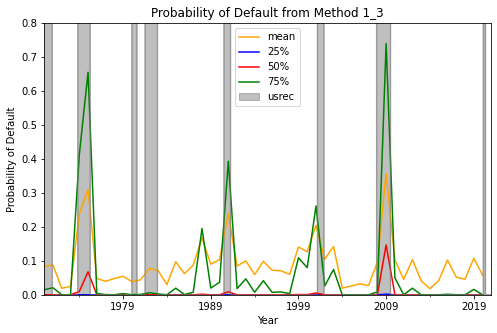

In [970]:
# PD of Method 1_3 with recession shade
fig, ax = plt.subplots()
pd_1_3[['year','mean','25%','50%','75%']].plot.line(ax=ax, figsize=(8, 5), x='year', color=['orange','blue','red','green'])
nber.plot.area(ax=ax, figsize=(8, 5), x='date', alpha=0.5, color="gray")
plt.ylim(0, 0.8)
plt.title('Probability of Default from Method 1_3')
plt.xlabel('Year')
plt.ylabel('Probability of Default')

Text(0, 0.5, 'Probability of Default')

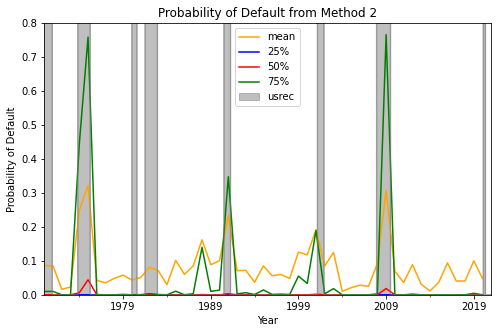

In [971]:
# PD of Method 2 with recession shade
fig, ax = plt.subplots()
pd_2[['year','mean','25%','50%','75%']].plot.line(ax=ax, figsize=(8, 5), x='year', color=['orange','blue','red','green'])
nber.plot.area(ax=ax, figsize=(8, 5), x='date', alpha=0.5, color="gray")
plt.ylim(0, 0.8)
plt.title('Probability of Default from Method 2')
plt.xlabel('Year')
plt.ylabel('Probability of Default')

Text(0, 0.5, 'Probability of Default')

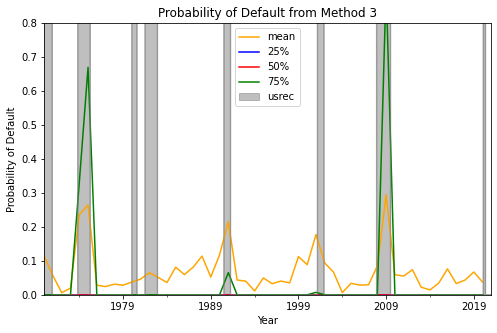

In [972]:
# PD of Method 3 with recession shade
fig, ax = plt.subplots()
pd_3[['year','mean','25%','50%','75%']].plot.line(ax=ax, figsize=(8, 5), x='year', color=['orange','blue','red','green'])
nber.plot.area(ax=ax, figsize=(8, 5), x='date', alpha=0.5, color="gray")
plt.ylim(0, 0.8)
plt.title('Probability of Default from Method 3')
plt.xlabel('Year')
plt.ylabel('Probability of Default')

4.4 PLOT DD AND PD WITH BAA-FED FUND SPREAD DATA

In [1123]:
# Create a function to plot DD with BAA-Fed Spread
def plot_dd_baa(df, title):
    fig, ax_1 = plt.subplots()
    baa.plot.line(x='date', ax=ax_1, ylabel='BAA-Fed Spread %', figsize=(8, 5), color='gray')
    ax_1.legend(loc='upper left')
    ax_2 = ax_1.twinx()
    df[['year','25%','50%','75%']].plot.line(x='year', ax=ax_2, ylabel='Distance to Default', figsize=(8, 5), color=['blue','red','green'])
    ax_2.legend(loc='lower right')
    ax_1.set_xlabel('Year')
    plt.title(title)
    

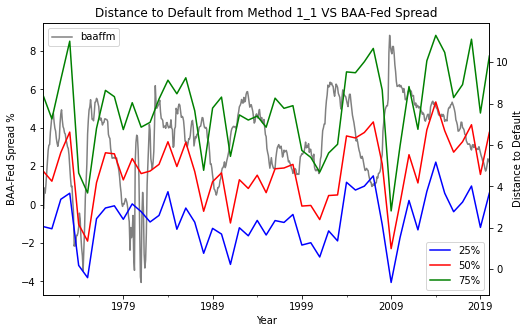

In [1124]:
# Plot DD of Method 1_1 with BAA-FED Spread
plot_dd_baa(dd_1_1, 'Distance to Default from Method 1_1 VS BAA-Fed Spread')

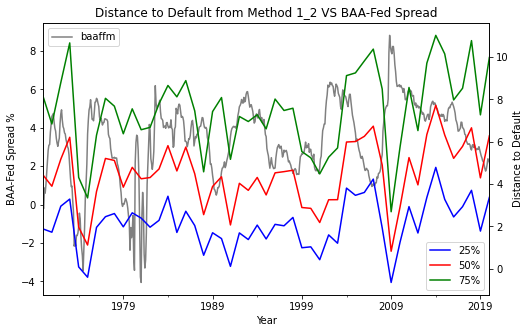

In [1125]:
# Plot DD of Method 1_2 with BAA-FED Spread
plot_dd_baa(dd_1_2, 'Distance to Default from Method 1_2 VS BAA-Fed Spread')

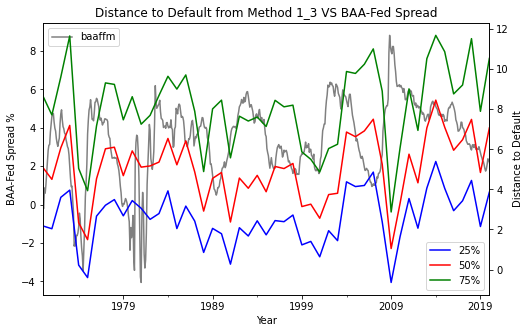

In [1126]:
# Plot DD of Method 1_3 with BAA-FED Spread
plot_dd_baa(dd_1_3, 'Distance to Default from Method 1_3 VS BAA-Fed Spread')

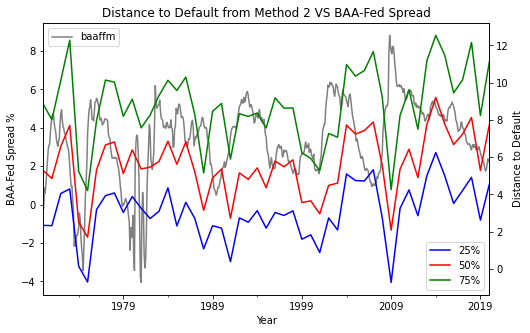

In [1127]:
# Plot DD of Method 2 with BAA-FED Spread
plot_dd_baa(dd_2, 'Distance to Default from Method 2 VS BAA-Fed Spread')

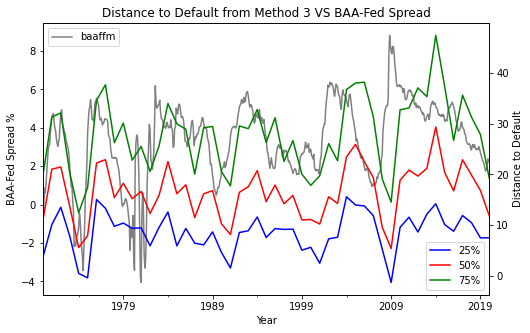

In [1128]:
# Plot DD of Method 3 with BAA-FED Spread
plot_dd_baa(dd_3, 'Distance to Default from Method 3 VS BAA-Fed Spread')

In [1131]:
# Create a function to plot PD with BAA-Fed Spread
def plot_pd_baa(df, title):
    fig, ax_1 = plt.subplots()
    baa.plot.line(x='date', ax=ax_1, ylabel='BAA-Fed Spread %', figsize=(8, 5), color='gray')
    ax_1.legend(loc='upper left')
    ax_2 = ax_1.twinx()
    df[['year','mean','25%','50%','75%']].plot.line(x='year', ax=ax_2, ylabel='Probability of Default', figsize=(8, 5), color=['orange','blue','red','green'])
    ax_2.legend(loc='upper right')
    ax_1.set_xlabel('Year')
    plt.title(title)

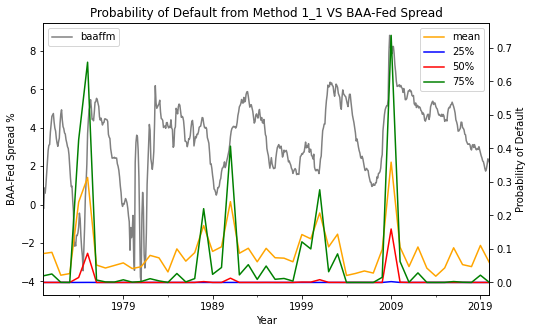

In [1132]:
# Plot PD of Method 1_1 with BAA-FED Spread
plot_pd_baa(pd_1_1, 'Probability of Default from Method 1_1 VS BAA-Fed Spread')

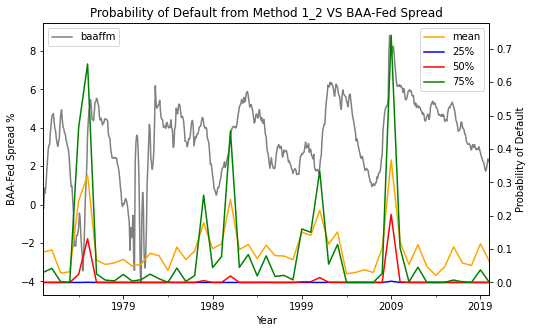

In [1133]:
# Plot PD of Method 1_2 with BAA-FED Spread
plot_pd_baa(pd_1_2, 'Probability of Default from Method 1_2 VS BAA-Fed Spread')

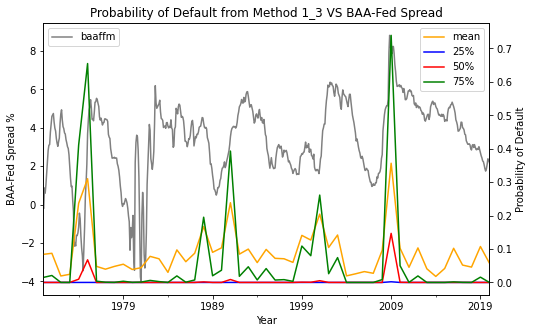

In [1134]:
# Plot PD of Method 1_3 with BAA-FED Spread
plot_pd_baa(pd_1_3, 'Probability of Default from Method 1_3 VS BAA-Fed Spread')

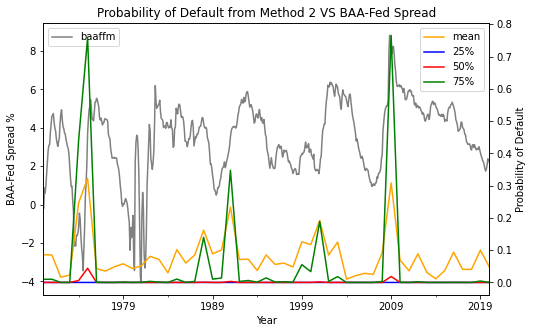

In [1135]:
# Plot PD of Method 2 with BAA-FED Spread
plot_pd_baa(pd_2, 'Probability of Default from Method 2 VS BAA-Fed Spread')

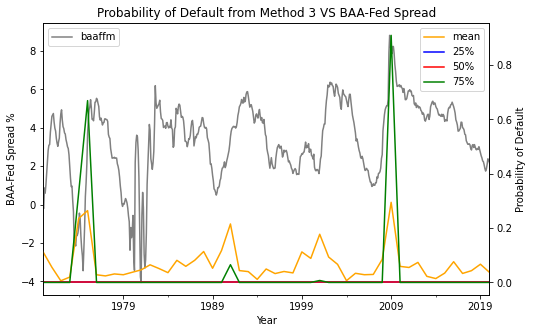

In [1136]:
# Plot PD of Method 3 with BAA-FED Spread
plot_pd_baa(pd_3, 'Probability of Default from Method 3 VS BAA-Fed Spread')

4.5 Plot DD and PD with Kansas City Financial Stress Index

In [1139]:
# Create a function to plot DD with KCFSI
def plot_dd_kcfsi(df, title):
    fig, ax_1 = plt.subplots()
    kcfsi.plot.line(x='date', ax=ax_1, ylabel='KCFSI', figsize=(8, 5), color='gray')
    ax_1.legend(loc='upper left')
    ax_2 = ax_1.twinx()
    df[['year','25%','50%','75%']].plot.line(x='year', ax=ax_2, ylabel='Distance to Default', figsize=(8, 5), color=['blue','red','green'])
    ax_2.legend(loc='upper center')
    ax_1.set_xlabel('Year')
    plt.title(title)

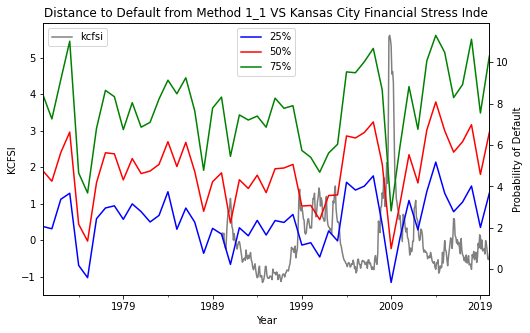

In [1141]:
# Plot DD of Method 1_1 with  Kansas City Financial Stress Index
plot_dd_kcfsi(dd_1_1, 'Distance to Default from Method 1_1 VS Kansas City Financial Stress Inde')

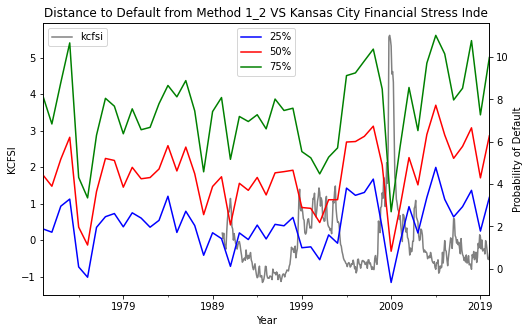

In [1142]:
# Plot DD of Method 1_2 with  Kansas City Financial Stress Index
plot_dd_kcfsi(dd_1_2, 'Distance to Default from Method 1_2 VS Kansas City Financial Stress Inde')

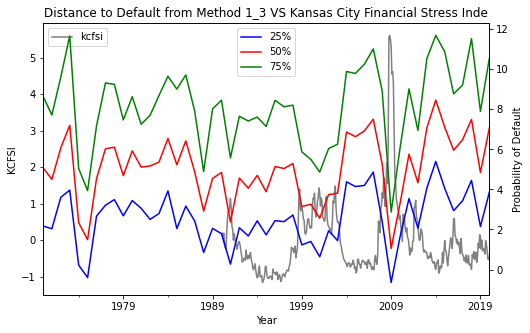

In [1143]:
# Plot DD of Method 1_3 with  Kansas City Financial Stress Index
plot_dd_kcfsi(dd_1_3, 'Distance to Default from Method 1_3 VS Kansas City Financial Stress Inde')

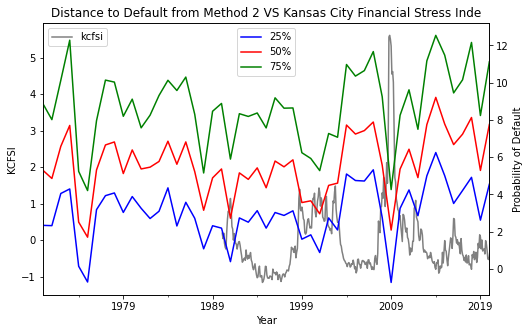

In [1144]:
# Plot DD of Method 2 with  Kansas City Financial Stress Index
plot_dd_kcfsi(dd_2, 'Distance to Default from Method 2 VS Kansas City Financial Stress Inde')

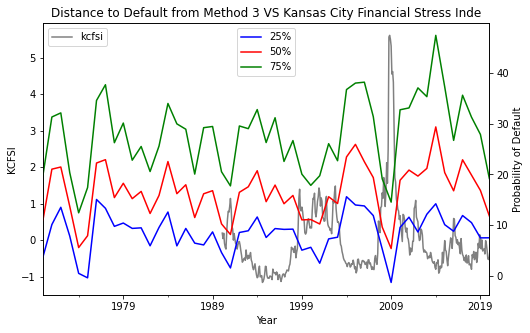

In [1145]:
# Plot DD of Method 3 with  Kansas City Financial Stress Index
plot_dd_kcfsi(dd_3, 'Distance to Default from Method 3 VS Kansas City Financial Stress Index')

In [1148]:
# Create a function to plot PD with KCFSI
def plot_pd_kcfsi(df, title):
    fig, ax_1 = plt.subplots()
    kcfsi.plot.line(x='date', ax=ax_1, ylabel='KCFSI', figsize=(8, 5), color='gray')
    ax_1.legend(loc='upper left')
    ax_2 = ax_1.twinx()
    df[['year','mean','25%','50%','75%']].plot.line(x='year', ax=ax_2, ylabel='Probability of Default', figsize=(8, 5), color=['orange','blue','red','green'])
    ax_2.legend(loc='upper right')
    ax_1.set_xlabel('Year')
    plt.title(title)

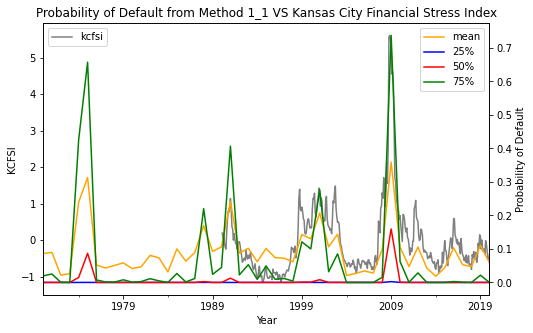

In [1149]:
# Plot PD of Method 1_1 with KCFSI
plot_pd_kcfsi(pd_1_1, 'Probability of Default from Method 1_1 VS Kansas City Financial Stress Index')

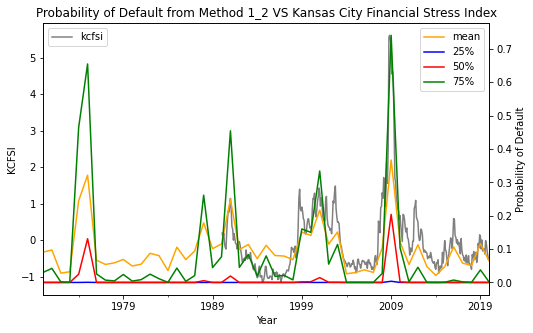

In [1150]:
# Plot PD of Method 1_2 with KCFSI
plot_pd_kcfsi(pd_1_2, 'Probability of Default from Method 1_2 VS Kansas City Financial Stress Index')

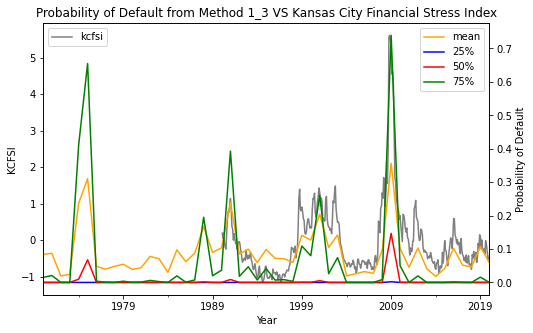

In [1151]:
# Plot PD of Method 1_3 with KCFSI
plot_pd_kcfsi(pd_1_3, 'Probability of Default from Method 1_3 VS Kansas City Financial Stress Index')

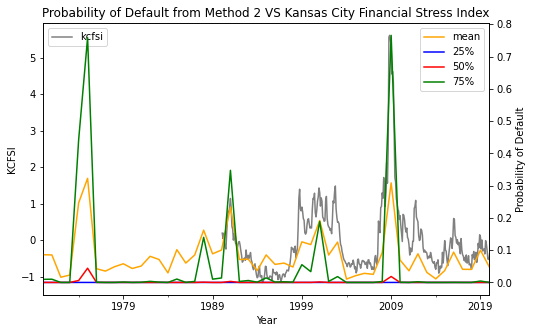

In [1152]:
# Plot PD of Method 2 with KCFSI
plot_pd_kcfsi(pd_2, 'Probability of Default from Method 2 VS Kansas City Financial Stress Index')

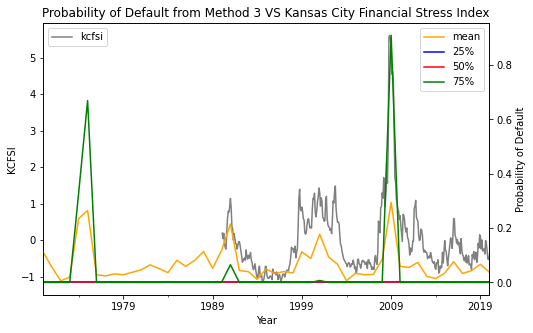

In [1153]:
# Plot PD of Method 3 with KCFSI
plot_pd_kcfsi(pd_3, 'Probability of Default from Method 3 VS Kansas City Financial Stress Index')